# Dask example
Shortened notebook to show reading of ECHAM Salsa data with dask

load dask and prepare for monitoring with a dashboard

In [1]:
# general
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import os
import intake

# dask
import dask
from dask.distributed import Client
client = Client()
client

# launch dashboard requires that you wait "a moment" to properly start.
# (Workers appear with small blue bars).

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/fc%3Auid%3A6e025f8a-ece1-4b09-902e-b0ad7712fca5/proxy/8787/status,
Dashboard: /user/fc%3Auid%3A6e025f8a-ece1-4b09-902e-b0ad7712fca5/proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34885,Workers: 4
Dashboard: /user/fc%3Auid%3A6e025f8a-ece1-4b09-902e-b0ad7712fca5/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:34155,Total threads: 4
Dashboard: /user/fc%3Auid%3A6e025f8a-ece1-4b09-902e-b0ad7712fca5/proxy/36313/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:34511,


# Opening of the file, and use dask

shortened to two species, (see also salsa_intro notebook)

In [2]:
filename = '/mnt/craas2-ns9988k/data/catalogs/salsa_catalog.json'
col = intake.open_esm_datastore(filename)
col.df['species'].unique()
cat = col.search(species=['bc','h2so4'], #,'du','ss','h2so4','oc'], #, now we get only the mass mixing ratios for all species
                 vertical_coord='pressure' # or 'hybrid' if you are fancy. This is only up to ~200hPa
                # start_time=["2012-01-01"],
                # end_time=["2015-01-01"]
				#bin_index= ["i1"],
				#variable = ["h2so4_1a1"],
				#bin = ["1a1"],
				#soluble = [True'],
				#unit = ['kg/kg']
                )
cat.df['species'].unique()
# USES DASK
dset_dict = cat.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'bin_index'


/opt/conda/envs/pangeo-notebook/lib/python3.11/site-packages/intake_esm/core.py:253: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/opt/conda/envs/pangeo-notebook/lib/python3.11/site-packages/intake_esm/core.py:253: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/opt/conda/envs/pangeo-notebook/lib/python3.11/site-packages/intake_esm/core.py:253: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = gr

Exception ignored in: <function CachingFileManager.__del__ at 0x7fa8e5466ca0>
Traceback (most recent call last):
  File "/opt/conda/envs/pangeo-notebook/lib/python3.11/site-packages/xarray/backends/file_manager.py", line 250, in __del__
    self.close(needs_lock=False)
  File "/opt/conda/envs/pangeo-notebook/lib/python3.11/site-packages/xarray/backends/file_manager.py", line 234, in close
    file.close()
  File "src/netCDF4/_netCDF4.pyx", line 2669, in netCDF4._netCDF4.Dataset.close
  File "src/netCDF4/_netCDF4.pyx", line 2636, in netCDF4._netCDF4.Dataset._close
  File "src/netCDF4/_netCDF4.pyx", line 2164, in netCDF4._netCDF4._ensure_nc_success
RuntimeError: NetCDF: Not a valid ID


# Compute mean and use dask
Invoke computation of mean values with compute command

In [3]:
# read the csv with station information
station_file = pd.read_csv('/mnt/craas2-ns9988k-dl-ns9560k/chrisvbr/ECHAM-SALSA-data/locations.csv', delimiter = ',', index_col=0)
names = np.array(station_file.columns)

# replace ncells with station names
for key in dset_dict.keys():
    dset_dict[key] = dset_dict[key].rename({'ncells': 'station'}).reset_coords(drop=True)
    dset_dict[key]['station'] = ('station', names)
dset_dict['i1'].station

ZEP_mean = {}
for key, dataset in dset_dict.items():
    time_mean = dataset.mean(dim='time')  # Calculate the time mean
    ZEP_mean[key] = time_mean.sel(station="ZEP").isel(plev=21).compute()  # Select level and station

# Visualisation

quick..., after data are in the aggregated structure

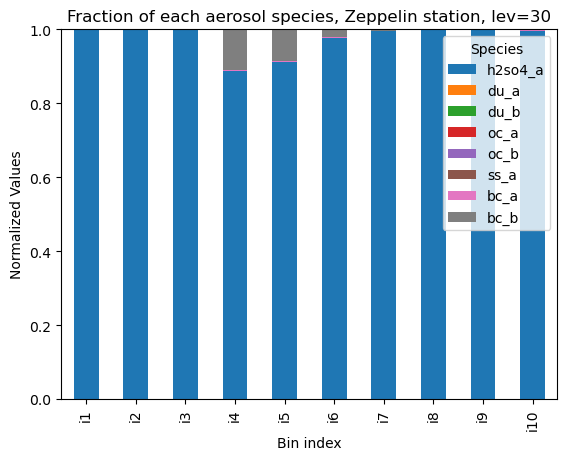

In [4]:
sorted_keys = sorted(ZEP_mean.keys(), key=lambda x: int(x[1:])) # sort by the bins by number (technically not necessary but it is neater)
ZEP_sorted = {key: ZEP_mean[key] for key in sorted_keys}

species_names = ['du_a', 'du_b', 'h2so4_a', 'oc_a', 'oc_b', 'ss_a'] # a for soluble, b for insoluble, consider changing this to du and du_insoluble
for key in ZEP_sorted.keys():
    varnames = list(ZEP_sorted[key].data_vars)
    species = [
        (s[:-3] + s[-2:-1])
        for s in varnames
		]
    rename_map = dict(zip(varnames, species))
    ZEP_sorted[key] = ZEP_sorted[key].rename(rename_map)
    for i in species_names:
        if i not in species:
            ZEP_sorted[key][i] = np.array(0.)

data = []
# Get values from each bin/variable
for bin_key in ZEP_sorted.keys():
    bin_values = {var_key: ZEP_sorted[bin_key][var_key].values.tolist() for var_key in ZEP_sorted[bin_key].keys()}

    # Add the bin values along with the bin key to the data list
    data.append({'bin_index': bin_key, **bin_values})

df = pd.DataFrame(data)
df.set_index('bin_index', inplace=True)

# Normalize the transposed DataFrame so that each category sums up to 1
df_normalized = df.div(df.sum(axis=1), axis=0)

# Create a stacked bar plot with categories on the x-axis
ax = df_normalized.plot(kind='bar', stacked=True)
plt.title("Fraction of each aerosol species, Zeppelin station, lev=30")
plt.xlabel("Bin index")
plt.ylabel("Normalized Values")
plt.legend(title="Species", loc='upper right')
plt.ylim(0, 1)
plt.show()